In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [36]:
#Load user data and examine
takehome_users_df = pd.read_csv('takehome_users.csv')
takehome_users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [37]:
#Load engagement data and examine
takehome_engagement_df = pd.read_csv('takehome_user_engagement.csv')
takehome_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


After loading the data, the first thing we want to do is check for missing data and handle it. 

In [38]:
#Check engagment data for missing data
takehome_engagement_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [39]:
#Check user data for missing data
takehome_users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

We see that invited_by_user_id and last_session_creation_time both have a lot of missing values. Let's begin with invited_by_user_id. For this feature, I believe it would be appropriate to turn this column into a binary feature. Unless the plan is to target certain individuals if their referals stick around longer, it should be good enough to see if a user was invited or not.  

In [40]:
#Add a new column where value is False if invited_by_user_id is nan. Value is set to True otherwise.
takehome_users_df['invited_by_user'] = np.where(takehome_users_df['invited_by_user_id'].isna(), 
                                                False, True)
#Drop this now redudant column
takehome_users_df.drop('invited_by_user_id', axis=1, inplace=True)
#Examine df to ensure change
takehome_users_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,True
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,True
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,False
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,True


For the last_session_creation_time missing data, one of two things is likely happening. Either there is a problem with the system and some users are not having their last session data stored correctly, or those users haven't logged in since they created their account. Since the last line of thinking seems more likely and also gives us a path of action, lets run with that assumption. We can set the missing data points to the creation dates. 

In [41]:
#Let's start by turning these dates into datetime objects
takehome_users_df['creation_time'] = pd.to_datetime(takehome_users_df['creation_time'])
takehome_users_df['last_session_creation_time'] = pd.to_datetime(takehome_users_df['last_session_creation_time'],
                                                                unit='s')
#Examine df to ensure change was made
takehome_users_df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user                         bool
dtype: object

In [42]:
#Now we can set the missing values to the creation dates
takehome_users_df['last_session_creation_time'] =\
np.where(takehome_users_df['last_session_creation_time'].isna(), 
         takehome_users_df['creation_time'], 
         takehome_users_df['last_session_creation_time'])
#We can see the change take place in rows 3 and 4.
takehome_users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,True


In [43]:
#Missing values should now be handled
takehome_users_df.isna().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user               0
dtype: int64

Now that we have handled missing values for the users data, let's work on wrangling the engagment data. First thing we want to do is convert the time_stamp column into a datetime object. Let's also make the time_stamp column the index. We can then aggregate the these timestamp objects into 7 day periods.

In [44]:
#Check dtypes of dataframe
takehome_engagement_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [45]:
#Convert time_stamp column to datetime objects.
takehome_engagement_df['time_stamp'] = pd.to_datetime(takehome_engagement_df['time_stamp'])
#Check dtypes again to ensure that our change has taken place
takehome_engagement_df.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [46]:
#Make time_stamp the new index
takehome_engagement_df.set_index('time_stamp', inplace=True)
#Examine new df
takehome_engagement_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [47]:
#Now we can aggregate the data into 7 day periods
#We can also groupby user_id first to perserve this value
grouped = takehome_engagement_df.groupby('user_id').resample('1w').sum()
grouped

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0
...                     ...      ...
11996   2013-09-08    11996        1
11997   2013-01-20    11997        1
11998   2014-04-27    11998        1
11999   2012-06-03    11999        1
12000   2014-01-26    12000        1

[82282 rows x 2 columns]

In [48]:
#We can now use this aggregated df to get a list of unique user_id's that 
#have visited more than three times in at least one 7 day period.
adopted = grouped[grouped['visited'] >= 3]['user_id'].unique()
#Check number of adopted users
len(adopted)

4453

Now that we have a list of all the user id's of adopted users, we can create a new feature in our user data dataframe showing whether or not a user was adopted.

In [49]:
#Add adopted column. 1 if user id in adopted list. 0 if not in list
takehome_users_df['adopted'] = np.where(takehome_users_df['object_id'].isin(adopted), 1, 0)
#Examine dataframe after new column
takehome_users_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,True,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,True,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,True,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,True,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,True,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,True,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,False,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,2013-07-31 05:34:02,1,1,74,False,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,2013-11-05 04:04:24,0,0,302,False,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,True,0


Now that we have labeled and wrangled our data, let's get to analyzing it. Let's check out a few distributions and see what we can learn about our data.

In [50]:
#To make the data easier to read
plt.rcParams['figure.figsize'] = (10, 10)
sns.set()

<AxesSubplot:xlabel='adopted', ylabel='opted_in_to_mailing_list'>

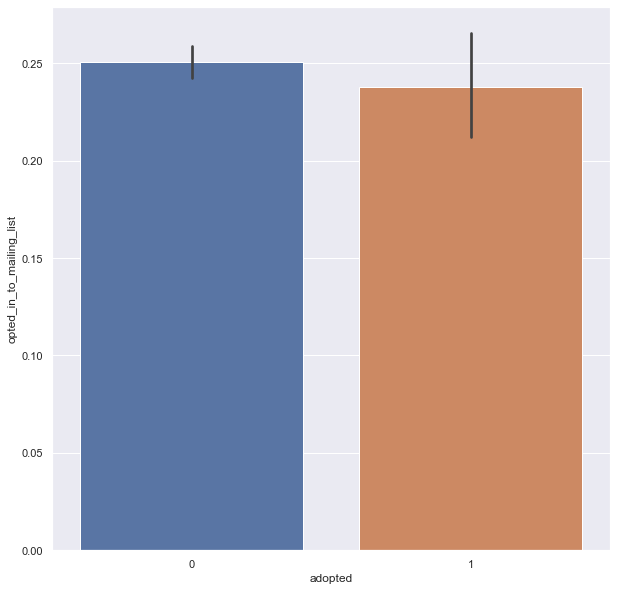

In [51]:
#Examine adopted users by if they opted into the mailing list
sns.barplot(x='adopted', y='opted_in_to_mailing_list', data=takehome_users_df)

In [52]:
#Let's run a t-test to see if this distribution is significant
stats.ttest_ind(takehome_users_df['adopted'][takehome_users_df['opted_in_to_mailing_list']==1], 
                takehome_users_df['adopted'][takehome_users_df['opted_in_to_mailing_list']==0])

Ttest_indResult(statistic=-0.8956826539237972, pvalue=0.370440246333652)

<AxesSubplot:xlabel='adopted', ylabel='enabled_for_marketing_drip'>

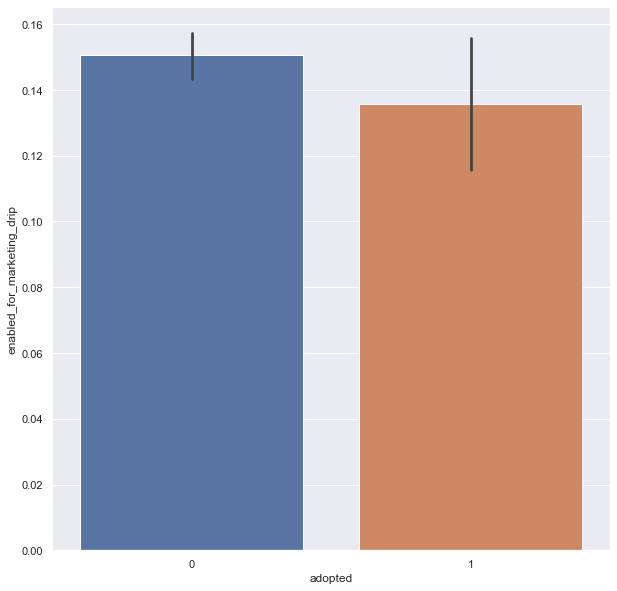

In [53]:
#Examine distribution of adopted within marketing drip
sns.barplot(x='adopted', y='enabled_for_marketing_drip', data=takehome_users_df)

In [54]:
#Let's run a t-test to see if this distribution is significant
stats.ttest_ind(takehome_users_df['adopted'][takehome_users_df['enabled_for_marketing_drip']==1], 
                takehome_users_df['adopted'][takehome_users_df['enabled_for_marketing_drip']==0])

Ttest_indResult(statistic=-1.2895676233751265, pvalue=0.19722568083198977)

<AxesSubplot:xlabel='adopted', ylabel='invited_by_user'>

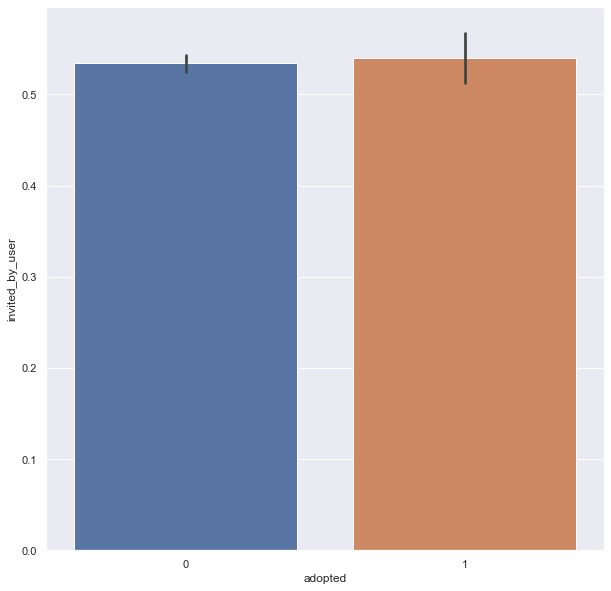

In [55]:
sns.barplot(x='adopted', y='invited_by_user', data=takehome_users_df)

In [56]:
#Let's run a t-test to see if this distribution is significant
stats.ttest_ind(takehome_users_df['adopted'][takehome_users_df['invited_by_user']==1], 
                takehome_users_df['adopted'][takehome_users_df['invited_by_user']==0])

Ttest_indResult(statistic=0.3666484012807925, pvalue=0.7138877652272173)

These simple distributions yielded no significant results. Let's examine some more interesting distributions. 

<AxesSubplot:xlabel='adopted', ylabel='creation_source'>

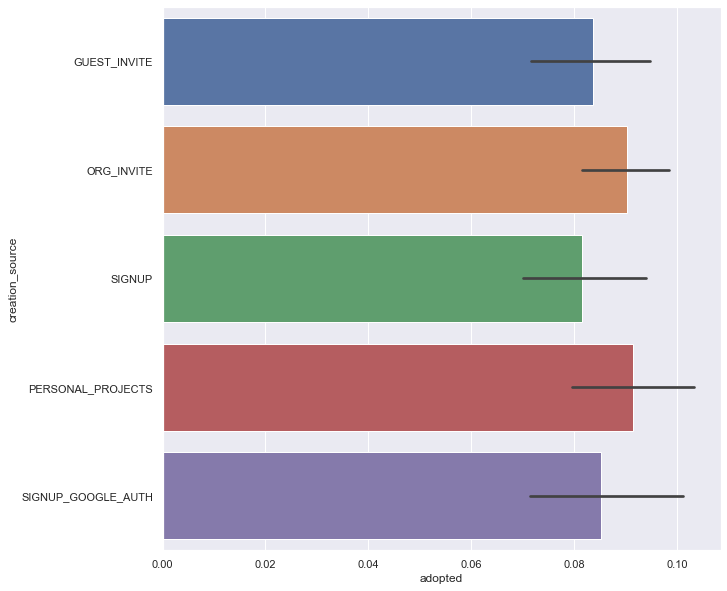

In [57]:
#Examine adopted across creation_source
sns.barplot(x='adopted', y='creation_source', data=takehome_users_df)

In [58]:
#Need a anova test for this since there are more than on categories
guest = takehome_users_df['adopted'][takehome_users_df['creation_source'] == 'GUEST_INVITE']
org = takehome_users_df['adopted'][takehome_users_df['creation_source'] == 'ORG_INVITE']
signup = takehome_users_df['adopted'][takehome_users_df['creation_source'] == 'SIGNUP']
personal = takehome_users_df['adopted'][takehome_users_df['creation_source'] == 'PERSONAL_PROJECTS']
google = takehome_users_df['adopted'][takehome_users_df['creation_source'] == 'SIGNUP_GOOGLE_AUTH']
stats.f_oneway(guest, org, signup, personal, google)

F_onewayResult(statistic=0.562012112095443, pvalue=0.690247144522484)

<AxesSubplot:xlabel='adopted'>

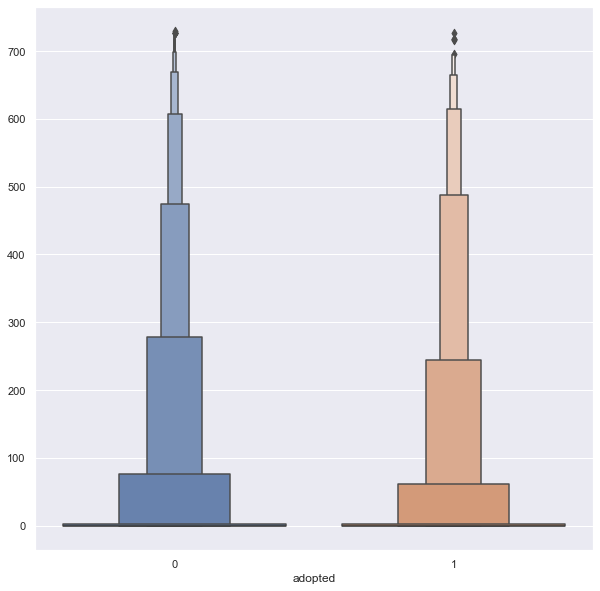

In [59]:
#Let's look at age of accounts vs adopted
#We will define account age by finding the difference between signup and last activity
age = (takehome_users_df['last_session_creation_time'] - takehome_users_df['creation_time'])\
        / np.timedelta64(1, 'D')
sns.boxenplot(x=takehome_users_df['adopted'], y=age)

In [60]:
#Let's now look at which orginizations, if any, have high percentage of adopted users. 
takehome_users_df[['org_id', 'adopted']].groupby('org_id').mean().sort_values('adopted', ascending=False)

,adopted
org_id,
412,0.352941
329,0.307692
271,0.294118
323,0.266667
380,0.238095
...,...
199,0.000000
376,0.000000
378,0.000000


Well creation_source and age didn't seem to produce any good results. There may be something in org_id, as some orginizations have higher percentages than others, but none are great. Let's now check out the time data and see if this yields any results. 

<AxesSubplot:xlabel='creation_time', ylabel='adopted'>

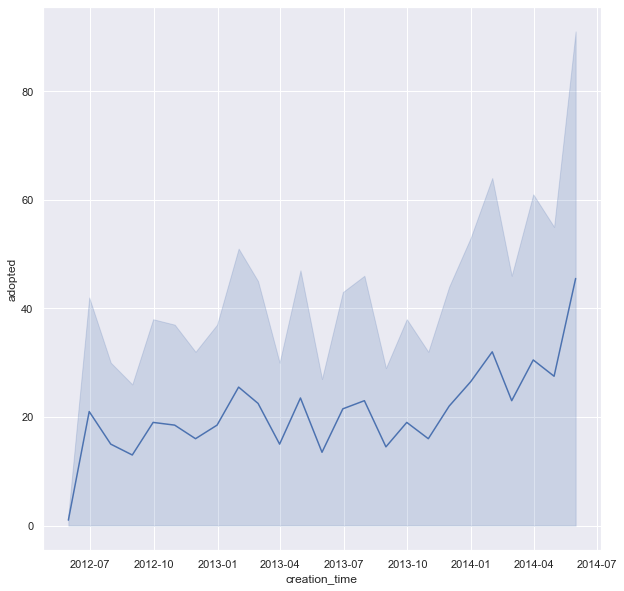

In [61]:
#Let's aggregate our data by month and see how adopted changes over time.
#Get just creation time and adotped columns.
creation_df = takehome_users_df[['creation_time', 'adopted']]
#Make creation_time the index
creation_df.set_index('creation_time', inplace=True)
#Resample by month
creation_df = creation_df.groupby('adopted').resample('1M').sum()
#Plot month vs adopted
sns.lineplot(x='creation_time', y='adopted', data=creation_df)

<AxesSubplot:xlabel='last_session_creation_time', ylabel='adopted'>

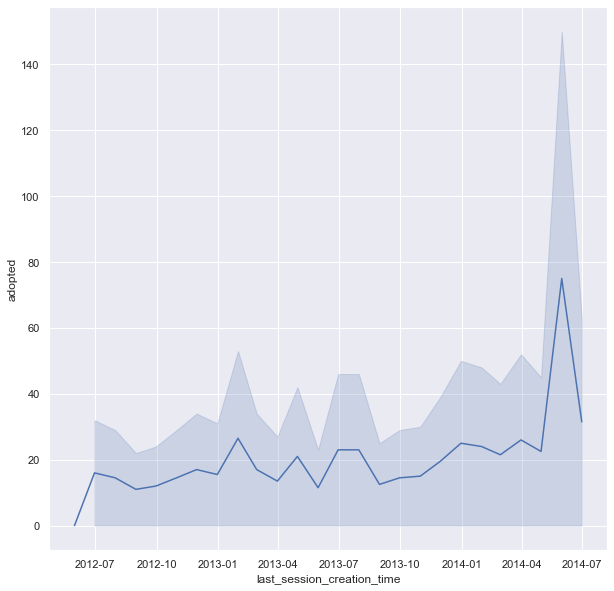

In [62]:
#Let's do the same thing for last_session_creation_time now
#Get just creation time and adotped columns.
last_df = takehome_users_df[['last_session_creation_time', 'adopted']]
#Make creation_time the index
last_df.set_index('last_session_creation_time', inplace=True)
#Resample by month
last_df = last_df.groupby('adopted').resample('1M').sum()
#Plot month vs adopted
sns.lineplot(x='last_session_creation_time', y='adopted', data=last_df)

There seems to be something about the middle of 2014 that has more adopted users in both time series. To capture this data let's break the timestamp columns apart into months and years. 

In [63]:
#Get year and month for creation_time
takehome_users_df['creation_month'] = takehome_users_df['creation_time'].dt.month
takehome_users_df['creation_year'] = takehome_users_df['creation_time'].dt.year
#Get year and month for last_session_creation_time
takehome_users_df['last_month'] = takehome_users_df['last_session_creation_time'].dt.month
takehome_users_df['last_year'] = takehome_users_df['last_session_creation_time'].dt.year
#Now that these times have been turned into months and years, we don't need them anymore.
takehome_users_df = takehome_users_df.drop(['creation_time', 'last_session_creation_time'], axis=1)
#Examine new df
takehome_users_df.head()

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,adopted,creation_month,creation_year,last_month,last_year
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,True,0,4,2014,4,2014
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,True,0,11,2013,3,2014
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,True,0,3,2013,3,2013
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,True,0,5,2013,5,2013
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,True,0,1,2013,1,2013


We have no examined many different distributions and time series. Let's now create a machine learning model and get its most important features. This will help us determine which features may be most important to focus on for adopting more users. 

In [64]:
#Our data is nice to read right now for humans, but still kinda difficult for machines.
#Let's hot encode some data and drop some not helpful columns.

#Email, name and object id are just identifiers and each is unique to its row.
#These rows aren't helpful for prediciting. 
model_df = takehome_users_df.drop(['name', 'object_id', 'email'], axis=1)
model_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,adopted,creation_month,creation_year,last_month,last_year
0,GUEST_INVITE,1,0,11,True,0,4,2014,4,2014
1,ORG_INVITE,0,0,1,True,0,11,2013,3,2014
2,ORG_INVITE,0,0,94,True,0,3,2013,3,2013
3,GUEST_INVITE,0,0,1,True,0,5,2013,5,2013
4,GUEST_INVITE,0,0,193,True,0,1,2013,1,2013


In [65]:
#creation_source and org_id are both categorical data, so let's hot encode them.
#We also want to months and years to be viewed as categories, so let's hot encode them as well.
model_df = pd.get_dummies(model_df, columns=['creation_source', 'org_id', 
                                             'creation_year', 'creation_month',
                                             'last_year', 'last_month'], drop_first=True)
model_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_1,org_id_2,...,last_month_3,last_month_4,last_month_5,last_month_6,last_month_7,last_month_8,last_month_9,last_month_10,last_month_11,last_month_12
0,1,0,True,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,True,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,True,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,True,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#Import logisitic regression library
from sklearn.linear_model import LogisticRegression
#Get dependant and independant variables
X = model_df.drop('adopted', axis=1)
y = model_df['adopted']
#Intialize model.
#No need to split as no testing will be done
log = LogisticRegression()
#Fit model
log.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Text(0.5, 1.0, 'Top 15 most important features')

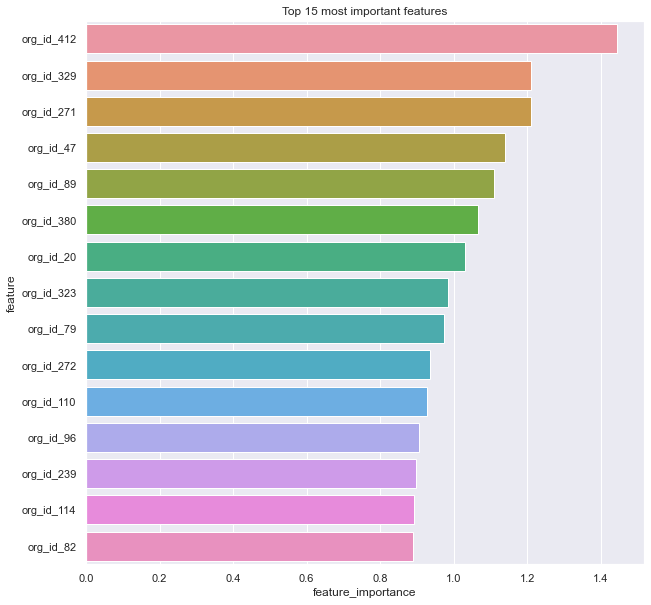

In [67]:
#Extract feature importances from model and make them into dataframes
feature_importance = pd.DataFrame({'feature': X.columns, 
                                         'feature_importance':[abs(i) for i in log.coef_[0]]})
#Plot most important features
sns.barplot(x='feature_importance', y='feature',
            data=feature_importance.sort_values('feature_importance', ascending=False).head(15))
plt.title('Top 15 most important features')

Text(0.5, 1.0, 'Top 15 most important features exluding org_id')

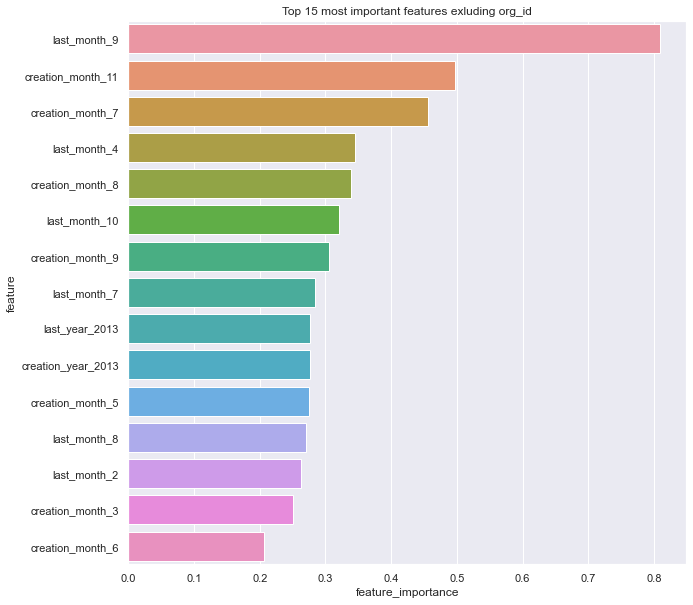

In [68]:
#Seems orginizations are important. Let's do this one more time without them.
#This is will help give us an idea on the second most important features. 
no_org_df = takehome_users_df.drop(['name', 'object_id', 'email', 'org_id'], axis=1)
#Hot encode data
no_org_df = pd.get_dummies(no_org_df, columns=['creation_source', 
                                             'creation_year', 'creation_month',
                                             'last_year', 'last_month'], drop_first=True)
#Get variables
X_no_org = no_org_df.drop('adopted', axis=1)
y_no_org = no_org_df['adopted']
#Create model
no_org_log = LogisticRegression()
#Fit model
no_org_log.fit(X_no_org, y_no_org)
#Extract feature importances from model and make them into dataframes
feature_importance_no_org = pd.DataFrame({'feature': X_no_org.columns, 
                                         'feature_importance':[abs(i) for i in no_org_log.coef_[0]]})
#Plot most important features
sns.barplot(x='feature_importance', y='feature',
            data=feature_importance_no_org.sort_values('feature_importance', ascending=False).head(15))
plt.title('Top 15 most important features exluding org_id')